# Explaining some causes behind different project riks 
## Scenarios number 2

### What is the effect of communication on the time delay (bugs)? 
- Task: Effect estimation

In [2]:
# Imports
import pandas as pd
import numpy as np
import pygraphviz
import matplotlib.pyplot as plt
import dowhy
import networkx as nx
from dowhy import CausalModel
from dowhy import gcm

#### Initialization

In [3]:
data_path = "../data/useable/brave-browser/clean_tasks.csv"
# Filter the dataset to include only rows after 2019 based on "authored_at" column

dataset = pd.read_csv(data_path)

print(len(dataset))

1458


### Step-1. Define causal models

Assumptions:
The potential treatment variables that can affect average cyclomatic complexity are:

1. Task-related variables:
    - task_type
    - has_bug_fixing
    - has_code_refactoring

2. Code-related variables:
    - loc
    - files_touched
    - contribution_complexity

3. People-related variables:
    - author
    - committer
    - author_experience
    - committer_experience
    - communication

4. Time-related variables:
    - authored_at
    - commited_at
    - commit_time_in_day
    - duration

In [4]:
causal_graph_nx = nx.DiGraph()

causal_graph_nx.add_node("task_type", label="Task Type")
causal_graph_nx.add_node("loc", label="Lines of Code (LOC)")
causal_graph_nx.add_node("files_touched", label="Number of Files Touched")
causal_graph_nx.add_node("code_quality", label="Code Quality")
causal_graph_nx.add_node("author", label="Author")
causal_graph_nx.add_node("committer", label="Committer")
causal_graph_nx.add_node("communication", label="Communication")
causal_graph_nx.add_node("author_experience", label="Author Experience")
causal_graph_nx.add_node("committer_experience", label="Committer Experience")
causal_graph_nx.add_node("contribution_complexity", label="Contribution Complexity")
causal_graph_nx.add_node("duration", label="Duration")
causal_graph_nx.add_node("avg_token", label="Avg. token count of functions.")
causal_graph_nx.add_node("total_nloc", label="Total lines of code without comments")
causal_graph_nx.add_node("avg_ccn", label="Avg. Cyclomatic Complexity Number")

causal_graph_nx.add_edge("task_type", "loc")
causal_graph_nx.add_edge("loc", "total_nloc")
causal_graph_nx.add_edge("total_nloc", "contribution_complexity")
causal_graph_nx.add_edge("total_nloc", "avg_ccn")
causal_graph_nx.add_edge("total_nloc", "avg_token")
causal_graph_nx.add_edge("total_nloc", "duration")
causal_graph_nx.add_edge("avg_token", "duration")
causal_graph_nx.add_edge("avg_ccn", "duration")
causal_graph_nx.add_edge("task_type", "files_touched")
causal_graph_nx.add_edge("task_type", "duration")
causal_graph_nx.add_edge("code_quality", "duration")
causal_graph_nx.add_edge("author", "communication")
causal_graph_nx.add_edge("committer", "communication")
causal_graph_nx.add_edge("communication", "duration")
causal_graph_nx.add_edge("loc", "contribution_complexity")
causal_graph_nx.add_edge("files_touched", "contribution_complexity")
causal_graph_nx.add_edge("author_experience", "duration")
causal_graph_nx.add_edge("committer_experience", "duration")
causal_graph_nx.add_edge("contribution_complexity", "code_quality")
causal_graph_nx.add_edge("contribution_complexity", "duration")


We defined the causal graph, but we still need to assign generative models to the nodes. With DoWhy, we can either manually specify those models, and configure them if needed, or automatically infer “appropriate” models using heuristics from data. We will leverage the latter here:

In [5]:
# Create the structural causal model object
scm = gcm.StructuralCausalModel(causal_graph_nx)

# Automatically assign generative models to each node based on the given data
gcm.auto.assign_causal_mechanisms(scm, dataset)

### Step 2: Fit causal models to data

After assigning a model to each node, we need to learn the parameters of the model:

In [6]:
gcm.fit(scm, dataset)

Fitting causal mechanism of node avg_ccn: 100%|█████████████████████████████████████████████████████████████| 14/14 [00:29<00:00,  2.11s/it]


The fit method learns the parameters of the generative models in each node. The fitted SCM can now be used to answer different kinds of causal questions.

### Step 3: Answer causal questions

At this point, we want to understand which factors drive changes in the duration. Let us first have a closer look at the duration over time. For this, we are using pandas to plot the duration over time, where the produced plot shows the duration on the Y-axis and the time on the X-axis.

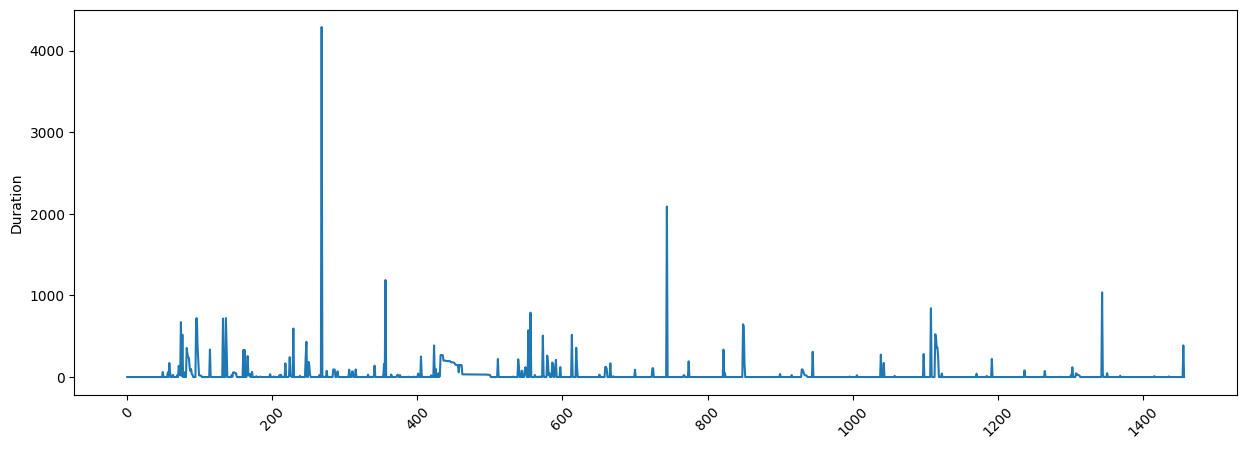

In [7]:
# Plot the graph
dataset['duration'].plot(ylabel='Duration', figsize=(15,5), rot=45)

# Save the figure
plt.savefig("question_2_plot_2" + ".jpg")

We see some significant spikes in the duration across the year. We can further quantify this by looking at the standard deviation, which we can estimate using the std() function from pandas:

In [8]:
dataset['duration'].std()

The estimated standard deviation of ~240.122206958985 is not quite significant.

From our causal graph, we see that multiple variables have a direct impact on the duration, but which of them contribute the most to the variance? To find this out, we can make use of the direct arrow strength algorithm that quantifies the causal influence of a specific arrow in the graph:

In [ ]:
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}


arrow_strengths = gcm.arrow_strength(scm, target_node='duration')

gcm.util.plot(causal_graph_nx, 
              filename="causal_model_q2_gcm",
              causal_strengths=convert_to_percentage(arrow_strengths), 
              figure_size=[30, 15])

In this causal graph, we see how much each node contributes to the variance of Average cyclomatic complexity. 
While the direct influences are helpful in understanding which direct parents influence the most on the variance in Average cyclomatic complexity, this mostly confirms our prior belief. The question of which factor is now ultimately responsible for this high variance is, however, still unclear. 

Although we could recursively apply the direct arrow strength to all nodes, we would not get a correctly weighted insight into the influence of upstream nodes on the variance.

What are the important causal factors contributing to the variance in average cyclomatic complexity? To find this out, we can use the DoWhy's intrinsic causal contribution method that attributes the variance in Profit to the upstream nodes in the causal graph. For this, we first define a function to plot the values in a bar plot and then use this to display the estimated contributions to the variance as a percentages: 

Estimating Shapley Values. Average change of Shapley values in run 6 (30 evaluated permutations): 0.639939595906891%: 100%|█| 1/1 [00:04<00:


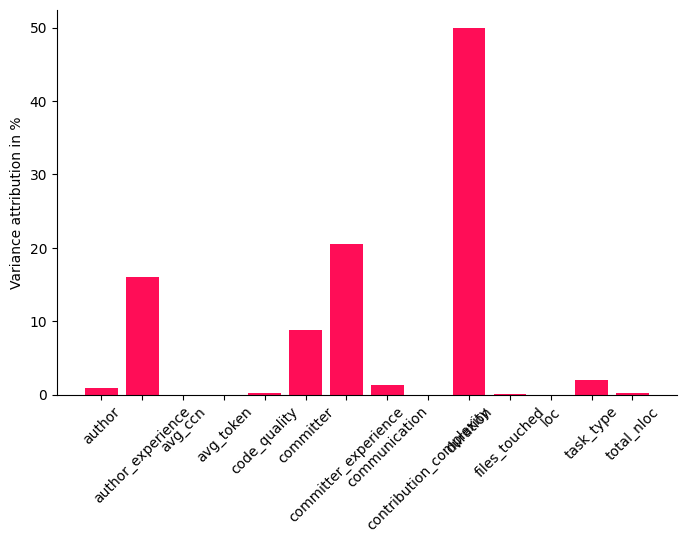

In [12]:
def bar_plot(value_dictionary, ylabel, uncertainty_attribs=None, figsize=(8, 5)):
    value_dictionary = {k: value_dictionary[k] for k in sorted(value_dictionary)}
    if uncertainty_attribs is None:
        uncertainty_attribs = {node: [value_dictionary[node], value_dictionary[node]] for node in value_dictionary}

    _, ax = plt.subplots(figsize=figsize)
    ci_plus = [uncertainty_attribs[node][1] - value_dictionary[node] for node in value_dictionary.keys()]
    ci_minus = [value_dictionary[node] - uncertainty_attribs[node][0] for node in value_dictionary.keys()]
    yerr = np.array([ci_minus, ci_plus])
    yerr[abs(yerr) < 10**-7] = 0
    plt.bar(value_dictionary.keys(), value_dictionary.values(), yerr=yerr, ecolor='#1E88E5', color='#ff0d57', width=0.8)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.show()


iccs = gcm.intrinsic_causal_influence(scm, target_node='duration', num_samples_randomization=500)

bar_plot(convert_to_percentage(iccs), ylabel='Variance attribution in %')

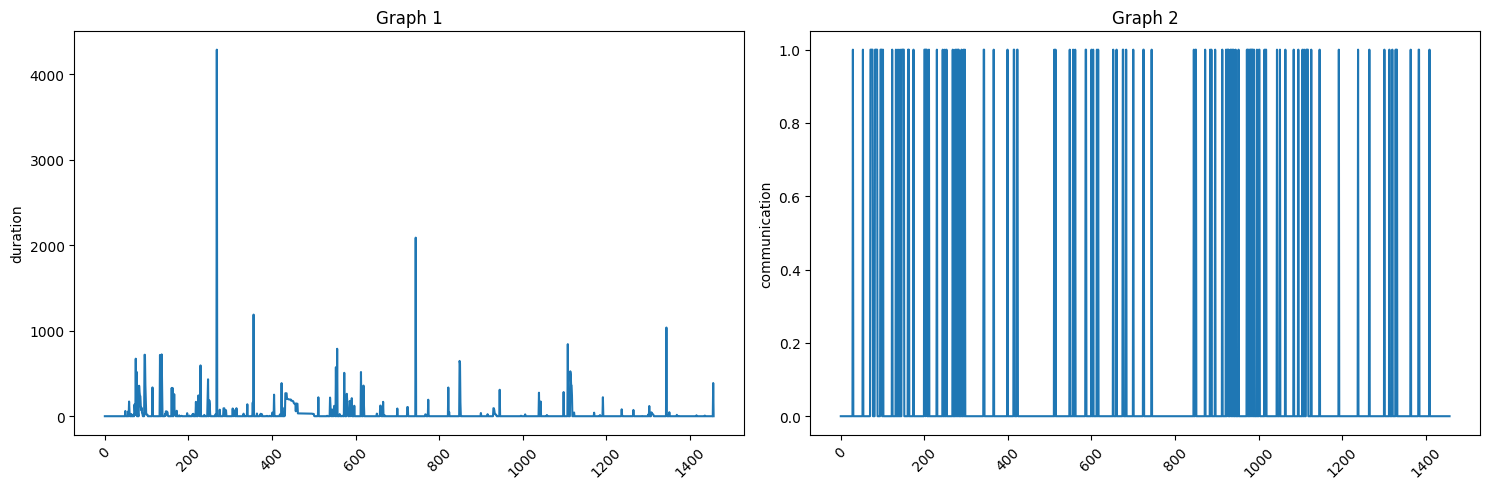

In [13]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first graph in the left subplot
dataset['duration'].plot(ax=axs[0], ylabel='duration', rot=45)
axs[0].set_title('Graph 1')

# Plot the second graph in the right subplot
dataset['communication'].plot(ax=axs[1], ylabel='communication', rot=45)
axs[1].set_title('Graph 2')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure
plt.savefig("question_2_plot_2" + ".jpg")

-- The end --